<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB3.1_Simple_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction with neural network


---

This notebook is the implementation of the example in the lecture notes, where we attemp to predict the outcomes of the process $$y(t)=\sin t + \sin 2t$$ on $t>10$ using the historical observations over $0\leq t\leq 10$.





As before, we import some standard packages to being with.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Now let's generate our historical samples on $0\leq t\leq 10$ and plot as well the true model values on the entire horizon say $0\leq t\leq 20$.

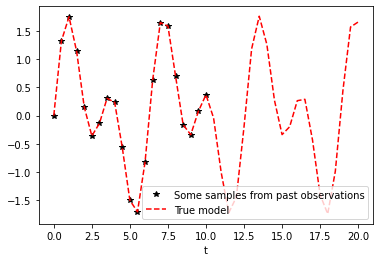

In [ ]:
step_size = 0.5 # Each time step in the time series represents 0.5 unit of calendar time

t_sample = np.arange(0, 10 + step_size, step_size)
t_all = np.arange(0, 20 + step_size, step_size)

obs_y = np.sin(t_sample) + np.sin(2*t_sample) # generate the samples
true_y = np.sin(t_all) + np.sin(2*t_all)  # generate the true outcomes over the complete time horizon

# Display 1 sample on the plot
plt.plot(t_sample,obs_y,'k*', label='Some samples from past observations')

# Plot the actual true model
plt.plot(t_all,true_y,'r--', label='True model')

plt.xlabel('t')
plt.legend()

# The naive approach

Now we try out the naive approach mentioned in the lecture notes, where we take the time index $t$ as the feature to predict $y(t)$. We use a feedforward neural network with 2 hidden layers with ReLU activations and 50 neurons on each layer.

There are not enough data points in this time series so we need to train the model over many epochs.

In [ ]:
MyModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(50, activation="relu", input_shape=(1,)),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

MyModel.compile(loss="mean_squared_error")
MyModel.fit(t_sample, obs_y, epochs=2000, verbose=0)

Now let's look at the predictions of the fitted model over $0\leq t\leq 20$.

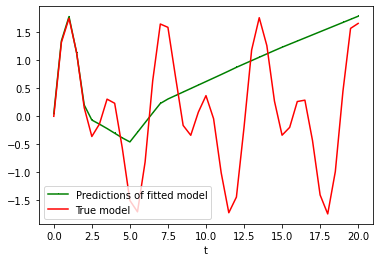

In [ ]:
pred_y = MyModel.predict(t_all)

plt.plot(t_all, pred_y, 'g-,', label="Predictions of fitted model")
plt.plot(t_all, true_y, 'r-', label="True model")
plt.xlabel('t')
plt.legend()

The neural network describes the true model relatively okay on $t\leq 10$ (where the model is trained by observations on this time range), but is absolutely terrible to predict the outcomes on $t>10$ which requires extrapolation.

While it is possible to improve the fit on $t\leq 10$ by considering a more complicated model, it is very hard to find one which describes the true model well over the entire horizon $0\leq t\leq 20$.

# Augmentation of the time series data

As mentioned in the lecture notes, using the time index as feature is a bad idea, and we should agument the data structure by including the past observations of the time series as features as well.

To better visualise what is going on as we manipulate the data, it is conveneint to use the python package "pandas". It is a very powerful tool for fast and expressive data structure management.

To start with, we create an empty pandas dataframe and write the time index ("t_sample") and the observations ("obs_y") to this dataframe. We name the columns 't' and 'y(t)' respectively.

In [ ]:
import pandas as pd     # import the pandas package

# create an empty dataframe variable called "data"
data = pd.DataFrame()

# create a column with name 't', put the values from t_sample to this column
data['t'] = t_sample

# create a column with name 'y(t)', put the values from obs_y to this column
data['y(t)'] = obs_y

# let's look at what this dataframe is like now
display(data)

,t,y(t)
0,0.0,0.000000
1,0.5,1.320897
2,1.0,1.750768
3,1.5,1.138615
4,2.0,0.152495
5,2.5,-0.360452
6,3.0,-0.138295
7,3.5,0.306203
8,4.0,0.232556
9,4.5,-0.565412


We can now create new columns easily in a dataframe. For example, if we want to create a column 'y(t-1)' which contains the values of 'y(t)' but with a shift in the time index by one, this can be achieved by the function "shift".

**(Warning: the column name 'y(t-1)' can be a bit misleading. It refers to the value of y one-step before but in this example one time-step is actually covering a calendar time of 0.5 unit. So strictly speaking we should write 'y(t-0.5)' instead of 'y(t-1)' but it will make the name unnecessarily long)**

In [ ]:
data['y(t-1)'] = data['y(t)'].shift(1)
display(data)

,t,y(t),y(t-1)
0,0.0,0.000000,NaN
1,0.5,1.320897,0.000000
2,1.0,1.750768,1.320897
3,1.5,1.138615,1.750768
4,2.0,0.152495,1.138615
5,2.5,-0.360452,0.152495
6,3.0,-0.138295,-0.360452
7,3.5,0.306203,-0.138295
8,4.0,0.232556,0.306203
9,4.5,-0.565412,0.232556


Let's creat a few more lagged columns (say up to $y(t-5)$ so in total we are using six historical values to predict the future outcome). We can do this by manual typing but it can also be done more conveniently via a for-loop.

In [ ]:
window_length = 6

for i in range(window_length - 1):
    col_name = 'y(t-{})'.format(i+1) # the name of each new column created is in form of 'y(t-i)' for i=1,2,...
    data[col_name] = data['y(t)'].shift(i+1)

display(data)

,t,y(t),y(t-1),y(t-2),y(t-3),y(t-4),y(t-5)
0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
1,0.5,1.320897,0.000000,NaN,NaN,NaN,NaN
2,1.0,1.750768,1.320897,0.000000,NaN,NaN,NaN
3,1.5,1.138615,1.750768,1.320897,0.000000,NaN,NaN
4,2.0,0.152495,1.138615,1.750768,1.320897,0.000000,NaN
5,2.5,-0.360452,0.152495,1.138615,1.750768,1.320897,0.000000
6,3.0,-0.138295,-0.360452,0.152495,1.138615,1.750768,1.320897
7,3.5,0.306203,-0.138295,-0.360452,0.152495,1.138615,1.750768
8,4.0,0.232556,0.306203,-0.138295,-0.360452,0.152495,1.138615
9,4.5,-0.565412,0.232556,0.306203,-0.138295,-0.360452,0.152495


We also need to prepare the label that we want to predict. Say we want to predict the one-step ahead outcome $y(t+1)$. Then the label can be created by the "shift" function as well but this time we use a negative shifting index.

In [ ]:
data['y(t+1)'] = data['y(t)'].shift(-1)
display(data)

,t,y(t),y(t-1),y(t-2),y(t-3),y(t-4),y(t-5),y(t+1)
0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,1.320897
1,0.5,1.320897,0.000000,NaN,NaN,NaN,NaN,1.750768
2,1.0,1.750768,1.320897,0.000000,NaN,NaN,NaN,1.138615
3,1.5,1.138615,1.750768,1.320897,0.000000,NaN,NaN,0.152495
4,2.0,0.152495,1.138615,1.750768,1.320897,0.000000,NaN,-0.360452
5,2.5,-0.360452,0.152495,1.138615,1.750768,1.320897,0.000000,-0.138295
6,3.0,-0.138295,-0.360452,0.152495,1.138615,1.750768,1.320897,0.306203
7,3.5,0.306203,-0.138295,-0.360452,0.152495,1.138615,1.750768,0.232556
8,4.0,0.232556,0.306203,-0.138295,-0.360452,0.152495,1.138615,-0.565412
9,4.5,-0.565412,0.232556,0.306203,-0.138295,-0.360452,0.152495,-1.502945


Notice that there are a lot of NaN values in the dataframe because they are not well-defined. We can drop all the rows with NaN values using the function "dropna()".

In [ ]:
data=data.dropna()
display(data)

,t,y(t),y(t-1),y(t-2),y(t-3),y(t-4),y(t-5),y(t+1)
5,2.5,-0.360452,0.152495,1.138615,1.750768,1.320897,0.000000,-0.138295
6,3.0,-0.138295,-0.360452,0.152495,1.138615,1.750768,1.320897,0.306203
7,3.5,0.306203,-0.138295,-0.360452,0.152495,1.138615,1.750768,0.232556
8,4.0,0.232556,0.306203,-0.138295,-0.360452,0.152495,1.138615,-0.565412
9,4.5,-0.565412,0.232556,0.306203,-0.138295,-0.360452,0.152495,-1.502945
10,5.0,-1.502945,-0.565412,0.232556,0.306203,-0.138295,-0.360452,-1.705531
11,5.5,-1.705531,-1.502945,-0.565412,0.232556,0.306203,-0.138295,-0.815988
12,6.0,-0.815988,-1.705531,-1.502945,-0.565412,0.232556,0.306203,0.635287
13,6.5,0.635287,-0.815988,-1.705531,-1.502945,-0.565412,0.232556,1.647594
14,7.0,1.647594,0.635287,-0.815988,-1.705531,-1.502945,-0.565412,1.588288


Now we can extract the features and label from this dataframe.

In [ ]:
# the right-hand-side below asks the program to return all columns in the dataframe EXCEPT the ones with name 't' and 'y(t+1)'
# The returned columns will hence include 'y(t)', 'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)', 'y(t-5)' which are exactly the features we want to use
x_train = data.drop(columns=['t', 'y(t+1)'])

# we can the column 'y(t+1)' and assign it to the label variable
y_train = data[['y(t+1)']]

print(x_train, y_train)

        y(t)    y(t-1)    y(t-2)    y(t-3)    y(t-4)    y(t-5)
5  -0.360452  0.152495  1.138615  1.750768  1.320897  0.000000
6  -0.138295 -0.360452  0.152495  1.138615  1.750768  1.320897
7   0.306203 -0.138295 -0.360452  0.152495  1.138615  1.750768
8   0.232556  0.306203 -0.138295 -0.360452  0.152495  1.138615
9  -0.565412  0.232556  0.306203 -0.138295 -0.360452  0.152495
10 -1.502945 -0.565412  0.232556  0.306203 -0.138295 -0.360452
11 -1.705531 -1.502945 -0.565412  0.232556  0.306203 -0.138295
12 -0.815988 -1.705531 -1.502945 -0.565412  0.232556  0.306203
13  0.635287 -0.815988 -1.705531 -1.502945 -0.565412  0.232556
14  1.647594  0.635287 -0.815988 -1.705531 -1.502945 -0.565412
15  1.588288  1.647594  0.635287 -0.815988 -1.705531 -1.502945
16  0.701455  1.588288  1.647594  0.635287 -0.815988 -1.705531
17 -0.162910  0.701455  1.588288  1.647594  0.635287 -0.815988
18 -0.338869 -0.162910  0.701455  1.588288  1.647594  0.635287
19  0.074726 -0.338869 -0.162910  0.701455  1.588288  1

From the above, note that x_train and y_train still have the pandas dataframe format (i.e. they have some column names and each of them also has one artifical column showing the row indices) rather than simple numpy arrays. It is not a problem, and the TensorFlow model fitting function indeed allows pandas dataframe as input.

Now we define a feedforward neural network and train it. The key thing to note is that for the input shape, we now have more than one feautre (6 in our example: 'y(t)', 'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)', 'y(t-5)'). We reflect this by using "x_train.shape[1]" in the input shape specification in the input layer of the model.

In [ ]:
MyModel2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(50, activation="relu", input_shape=(x_train.shape[1],)),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

MyModel2.compile(loss="mean_squared_error")
MyModel2.fit(x_train, y_train, epochs=500, verbose=0)

Now let's try to verify the quality of the fitted model. We create a new dataframe which covers all the data points on the whole time horizon $0\leq t\leq 20$ from the 't_all' and 'true_y'. The procedures are the same as before so we don't further elaborate what the following segment of the code does.

In [ ]:
data2 = pd.DataFrame()

data2['t'] = t_all
data2['y(t)'] = true_y

for i in range(window_length - 1):
    col_name = 'y(t-{})'.format(i+1)
    data2[col_name] = data2['y(t)'].shift(i+1)

data2['y(t+1)'] = data2['y(t)'].shift(-1)

data2 = data2.dropna()

display(data2)

,t,y(t),y(t-1),y(t-2),y(t-3),y(t-4),y(t-5),y(t+1)
5,2.5,-0.360452,0.152495,1.138615,1.750768,1.320897,0.000000,-0.138295
6,3.0,-0.138295,-0.360452,0.152495,1.138615,1.750768,1.320897,0.306203
7,3.5,0.306203,-0.138295,-0.360452,0.152495,1.138615,1.750768,0.232556
8,4.0,0.232556,0.306203,-0.138295,-0.360452,0.152495,1.138615,-0.565412
9,4.5,-0.565412,0.232556,0.306203,-0.138295,-0.360452,0.152495,-1.502945
10,5.0,-1.502945,-0.565412,0.232556,0.306203,-0.138295,-0.360452,-1.705531
11,5.5,-1.705531,-1.502945,-0.565412,0.232556,0.306203,-0.138295,-0.815988
12,6.0,-0.815988,-1.705531,-1.502945,-0.565412,0.232556,0.306203,0.635287
13,6.5,0.635287,-0.815988,-1.705531,-1.502945,-0.565412,0.232556,1.647594
14,7.0,1.647594,0.635287,-0.815988,-1.705531,-1.502945,-0.565412,1.588288


Now we extrat the features from this dataframe and make predictions of y(t+1). We then write the predictions to the dataframe in a new column called 'predicted y(t+1)'.

In [ ]:
x_val = data2.drop(columns=['t', 'y(t+1)'])
pred_y = MyModel2.predict(x_val)

data2['predicted y(t+1)'] = pred_y
display(data2)

,t,y(t),y(t-1),y(t-2),y(t-3),y(t-4),y(t-5),y(t+1),predicted y(t+1)
5,2.5,-0.360452,0.152495,1.138615,1.750768,1.320897,0.000000,-0.138295,-0.166652
6,3.0,-0.138295,-0.360452,0.152495,1.138615,1.750768,1.320897,0.306203,0.281309
7,3.5,0.306203,-0.138295,-0.360452,0.152495,1.138615,1.750768,0.232556,0.202436
8,4.0,0.232556,0.306203,-0.138295,-0.360452,0.152495,1.138615,-0.565412,-0.586019
9,4.5,-0.565412,0.232556,0.306203,-0.138295,-0.360452,0.152495,-1.502945,-1.521098
10,5.0,-1.502945,-0.565412,0.232556,0.306203,-0.138295,-0.360452,-1.705531,-1.742028
11,5.5,-1.705531,-1.502945,-0.565412,0.232556,0.306203,-0.138295,-0.815988,-0.850207
12,6.0,-0.815988,-1.705531,-1.502945,-0.565412,0.232556,0.306203,0.635287,0.599992
13,6.5,0.635287,-0.815988,-1.705531,-1.502945,-0.565412,0.232556,1.647594,1.622313
14,7.0,1.647594,0.635287,-0.815988,-1.705531,-1.502945,-0.565412,1.588288,1.564889


Plot the predictions vs the true values. The one-step ahead predictions in general are very close to the true model values.

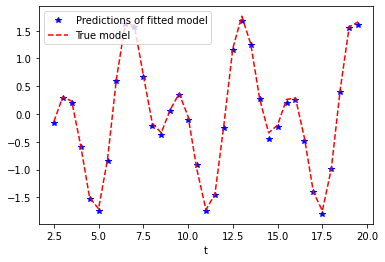

In [ ]:
plt.plot(data2['t'], data2['predicted y(t+1)'], 'b*', label="Predictions of fitted model")
plt.plot(data2['t'], data2['y(t+1)'], 'r--', label="True model")
plt.xlabel('t')
plt.legend()